In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, udf, year, month, dayofmonth, dayofweek, datediff, to_date, regexp_replace, length, unix_timestamp, from_unixtime, log
from pyspark.sql.types import DoubleType

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor, LinearRegression, GBTRegressor, RandomForestRegressionModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import re
import matplotlib.pyplot as plt
import pandas as pd
from constants import TEST_TRANSFORMED_DATA, TRAIN_TRANSFORMED_DATA, RANDOM_FOREST_MODEL

In [2]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("CO2 Emission ML Pipeline - Model Evaluation") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
23/11/14 17:58:56 WARN Utils: Your hostname, Kris resolves to a loopback address: 127.0.1.1; using 172.18.209.221 instead (on interface eth0)
23/11/14 17:58:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/14 17:58:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
#reading df
TEST_TRANSFORMED_DF = spark.read.parquet(TEST_TRANSFORMED_DATA)
TRAIN_TRANSFORMED_DF = spark.read.parquet(TRAIN_TRANSFORMED_DATA)

# loadign trained random forest model
rf_model = RandomForestRegressionModel.load(RANDOM_FOREST_MODEL)

# generating predictions
predictions = rf_model.transform(TEST_TRANSFORMED_DF)

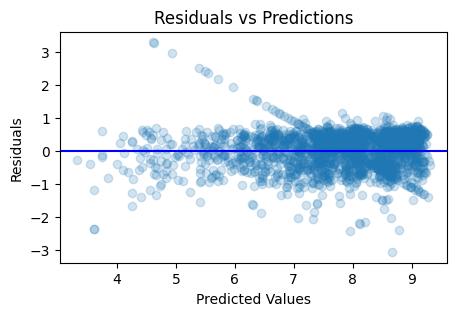

In [14]:
# calculate residuals
residuals = predictions.select('log_CO2_emission', 'prediction').rdd.map(lambda x: x[0] - x[1]).collect()

# extract predicted values
predicted_values = predictions.select('prediction').rdd.map(lambda x: x[0]).collect()

# plot residuals
plt.figure(figsize=(5, 3))
plt.scatter(predicted_values, residuals, alpha=0.2)
plt.title('Residuals vs Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='b', linestyle='-')
plt.show()

Interesting. So, looking at the plot we see that residuals are not randomly dispersed and they form a pattern indicating that the model might be missing some explanatory variable or that a non-linear relationship is not captured my the model. Also, it seems there are some outliers below -2 and -3 which indicate some anomaly in the data.

New methods can be apllied to improve the model by looking again into the data pre-processing. Also, more feature engineering could capture non-linear relationships.